In [1]:
import numpy as np

import astropy.table as tb 
from astropy.time import Time  
from astropy import units as u

from spacerocks.units import Units
from spacerocks.simulation import Simulation
from spacerocks.model import PerturberModel, builtin_models
from spacerocks.cbindings import correct_for_ltt_destnosim
from spacerocks.observer import Observer
from spacerocks.constants import epsilon

In [5]:
from utils import createRandomObjects
import destnosim

In [6]:
mjd = [52222, 53333]
objs = createRandomObjects(100)
population = destnosim.ElementPopulation(objs, 16)
times = Time(mjd, format='mjd', scale='utc')
rocks = population.generateSpaceRocks()

In [10]:
times.jd

array([2452222.5, 2453333.5])

In [19]:
obs = Observer.from_obscode('W84').at(times.jd[0])
obs.x.au.astype(np.double)

array([0.67823096])

In [22]:


def c1(population, mjd, progress=False):
	'''
	Calls the Spacerocks backend to generate observations for the input population


	Arguments:
	- population: Population object for the input orbits
	'''
	## first set up times and do spacerock stuff

	#self.createEarthSpaceRock()
	times = Time(mjd, format='mjd', scale='utc')
	rocks = population.generateSpaceRocks()

	units = Units()
	units.timescale = 'utc'
	units.timeformat = 'jd'
	units.mass = u.M_sun
    
	spiceids, kernel, masses = builtin_models['ORBITSPP']
	model = PerturberModel(spiceids=spiceids, masses=masses)
	
	sim = Simulation(model=model, epoch=times.jd[0], units=units)
	sim.add_spacerocks(rocks)
	sim.integrator = 'leapfrog'

	ras = np.array([])
	decs = np.array([])
	orbitid = np.array([])
	mjds = np.array([])
	oidlist = np.arange(len(population))
	xList = np.array([])
	yList = np.array([])
	zList = np.array([])
	dList = np.array([])

	if progress == True:
		from rich.progress import track
		epochs = track(range(len(times.jd)))
	else:
		epochs = range(len(times.jd))

	for i in epochs:
		sim.integrate(times.jd[i], exact_finish_time=1)
		a = np.zeros((sim.N, 3), dtype=np.double)
		b = np.zeros((sim.N, 3), dtype=np.double)
		sim.serialize_particle_data(xyz=a, vxvyvz=b)
		x, y, z = a.T
		vx, vy, vz = b.T
    
		x = np.ascontiguousarray(x)[sim.N_active:]
		y = np.ascontiguousarray(y)[sim.N_active:]
		z = np.ascontiguousarray(z)[sim.N_active:]
		vx = np.ascontiguousarray(vx)[sim.N_active:]
		vy = np.ascontiguousarray(vy)[sim.N_active:]
		vz = np.ascontiguousarray(vz)[sim.N_active:]

		xList = np.append(xList, x)
		yList = np.append(yList, y)
		zList = np.append(zList, z)
		dList = np.append(dList, np.sqrt(x**2 + y**2 + z**2))

		# observer = Observer(epoch=times.jd[i], obscode='W84', units=units)
		observer = Observer.from_obscode('W84').at(times.jd[i])
		ox = observer.x.au.astype(np.double)
		oy = observer.y.au.astype(np.double)
		oz = observer.z.au.astype(np.double)
		ovx = observer.vx.value.astype(np.double)
		ovy = observer.vy.value.astype(np.double)
		ovz = observer.vz.value.astype(np.double)
		
		# Compute ltt-corrected topocentroc Ecliptic coordinates
		xt, yt, zt = correct_for_ltt_destnosim(x, y, z, vx, vy, vz, ox, oy, oz, ovx, ovy, ovz)
		lon = np.arctan2(yt, xt)
		lat = np.arcsin(zt / np.sqrt(xt**2 + yt**2 + zt**2))
		dec = np.degrees(np.arcsin(np.sin(lat) * np.cos(epsilon) + np.cos(lat) * np.sin(lon) * np.sin(epsilon)))
		ra = np.degrees(np.arctan2((np.cos(lat) * np.cos(epsilon) * np.sin(lon) - np.sin(lat) * np.sin(epsilon)), np.cos(lon) * np.cos(lat)))

		ra[ra>180] -= 360

		orbitid = np.append(orbitid, oidlist)
		mjds = np.append(mjds, len(oidlist) * [i])

		ras = np.append(ras, ra)
		decs = np.append(decs, dec)


	del x, y, z, vx, vy, vz, a, b, sim, xt, yt, zt, ox, oy, oz, observer
	## gather data into something useable
	t = tb.Table()
	t['AstRA(deg)'] = ras
	del ras
	#t['RA'][t['RA'] > 180] -= 360
	t['AstDec(deg)'] = decs
	del decs
	t['ObjID'] = orbitid.astype('int64')
	del orbitid

	t['FieldMJD'] = mjds
	t['Mag'] = 20

	t['x'] = xList
	t['y'] = yList
	t['z'] = zList
	t['d'] = dList

	# ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Ast-Sun(J2000vx)(km/s),Ast-Sun(J2000vy)(km/s),Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(km),Obs-Sun(J2000y)(km),Obs-Sun(J2000z)(km),Obs-Sun(J2000vx)(km/s),Obs-Sun(J2000vy)(km/s),Obs-Sun(J2000vz)(km/s),Sun-Ast-Obs(deg),V,V(H=0),fiveSigmaDepth,filter,MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,dmagVignet,AstRATrue(deg),AstDecTrue(deg),detector,OBSCODE,NA

	return t

t = c1(population, mjd)

In [1]:
out_hl_file = "./temp/hl_out.csv"
out_hlsum_file = "./temp/hl_outsum.csv"

In [2]:
import pandas as pd
out = pd.read_csv(out_hl_file)
outs = pd.read_csv(out_hlsum_file)

In [4]:
out.head()

,#ptct,MJD,RA,Dec,idstring,mag,band,obscode,index1,index2,clusternum
0,0,60676.5,-64.096066,-39.067364,332,20.0,r,W84,278,334,1
1,1,60676.6,-64.093204,-39.066511,332,20.0,r,W84,279,734,1
2,2,60683.5,-63.893532,-39.005447,332,20.0,r,W84,1074,1134,1
3,3,60683.6,-63.890656,-39.004557,332,20.0,r,W84,1075,1534,1
4,4,60689.5,-63.720061,-38.950577,332,20.0,r,W84,1868,1934,1


In [5]:
outs.head()

,#clusternum,posRMS,velRMS,totRMS,pairnum,timespan,uniquepoints,obsnights,metric,rating,heliodist,heliovel,helioacc,posX,posY,posZ,velX,velY,velZ
0,1,51631.201,30010.974,59719.674,3,13.1,6,3,0.003948,PURE,1.1,-20.777,-0.0,5.634953e+07,-1.260091e+08,-8.956910e+07,-33.625130,7.909010,6.027471
1,2,52316.406,29278.979,59952.189,3,13.1,6,3,0.003933,PURE,1.1,-20.777,-0.0,3.676000e+07,-1.593648e+08,-1.864500e+07,-33.722199,13.567053,1.708722
2,3,49530.996,20657.767,53666.217,3,13.1,6,3,0.004394,PURE,1.1,-20.777,-0.0,2.754647e+07,-1.575026e+08,3.896143e+07,-31.890255,15.531877,-2.823956
3,4,54483.548,43755.498,69878.471,3,13.1,6,3,0.003374,PURE,1.1,-20.777,-0.0,2.835233e+07,-1.018999e+08,1.261582e+08,-33.406135,11.607883,-10.342922
4,5,51573.381,17486.948,54457.387,3,13.1,6,3,0.004330,PURE,1.1,-20.777,-0.0,6.247080e+07,-1.412369e+08,5.678750e+07,-33.932358,8.014560,-3.166290


In [19]:
# extract from heliolinc output
def get_idstring(cn):
    return out.loc[out['clusternum'] == cn].iloc[0, 4]

cn_list = outs['#clusternum']
idstring_list = [get_idstring(cn) for cn in cn_list]
len(idstring_list)

24429

In [31]:
cn_list = outs['#clusternum']
os_ids = out['idstring']
os_cn = out['clusternum']
cn_to_idstring = {}
for i in range(len(os_ids)):
    cn = os_cn[i]
    cn_to_idstring[cn] = os_ids[i]
idstring_list = [cn_to_idstring[cn] for cn in cn_list]
df = pd.DataFrame({'idstring': idstring_list, 'clusternum': cn_list,
                  'heliodist': outs['heliodist'], 'heliovel': outs['heliovel'], 'helioacc': outs['helioacc']})


,idstring,clusternum,heliodist,heliovel,helioacc
1285,32,1286,9.084,-6.926,-0.0
1481,32,1482,9.084,0.000,-0.0
1658,32,1659,9.084,6.926,-0.0
1823,32,1824,10.082,-6.926,-0.0
2033,32,2034,10.082,0.000,-0.0
...,...,...,...,...,...
11241,32,11242,24.053,0.000,-0.0
11334,32,11335,24.053,3.463,-0.0
11439,32,11440,24.053,3.463,-0.0
11773,32,11774,25.051,0.000,-0.0


In [11]:
import pandas as pd
import numpy as np
from astropy import units as u
dets_file = "./temp/dets.csv"

dets = pd.read_csv(dets_file)
dets

,AstRA(deg),AstDec(deg),ObjID,FieldMJD,Mag,Band,ObsCode,d,x,y,z
0,146.880943,-70.926404,0,60676.5,20,r,W84,57.405975,-16.037163,-11.399501,-53.928719
1,73.385684,-9.031649,1,60676.5,20,r,W84,7.312354,1.728094,6.364216,-3.159267
2,-169.787357,-13.878285,2,60676.5,20,r,W84,6.889236,-6.801367,-0.871236,-0.666284
3,85.516894,17.702490,3,60676.5,20,r,W84,19.363891,1.187183,19.273066,-1.449074
4,124.093986,-41.352853,4,60676.5,20,r,W84,45.390327,-19.277453,14.828428,-38.324656
...,...,...,...,...,...,...,...,...,...,...,...
2395,68.474889,56.450726,395,60689.6,20,r,W84,75.892685,14.821688,61.152317,42.431254
2396,29.965497,-12.440960,396,60689.6,20,r,W84,17.794389,14.782342,7.315026,-6.679299
2397,146.052389,45.815808,397,60689.6,20,r,W84,78.147336,-45.048880,50.410042,39.197349
2398,-11.555465,40.791620,398,60689.6,20,r,W84,8.916621,6.142160,1.884348,6.182980


In [13]:
# def calculate_helio_truth_value()
dets1 = dets[['ObjID', 'd', 'FieldMJD']]
dets1.sort_values('ObjID', inplace=True)
mjd_list_len = 6

/var/folders/0b/cvz14xc50n1g1h_jk2df5zzr0000gn/T/ipykernel_9408/138383047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dets1.sort_values('ObjID', inplace=True)


In [31]:
mjdRef = 60683.5
dList = dets1['d'].values
mjdList = (dets1['FieldMJD'] - mjdRef).values
objCount = int(len(dList) / mjd_list_len)
helioTruth = []
for oid in range(objCount):
    x = mjdList[oid * mjd_list_len: (oid + 1) * mjd_list_len] # day
    y = dList[oid * mjd_list_len: (oid + 1) * mjd_list_len] # AU
    fit = np.polyfit(x, y, 2)
    helioTruth.append(fit)

helioTruth = np.array(helioTruth)
ha, hv, hd = helioTruth.T
objDf = pd.DataFrame({'ObjID': np.arange(objCount), 'helioDist': hd, 'helioVel': hv, 'helioAcc': ha})
objDf

,ObjID,helioDist,helioVel,helioAcc
0,0,57.409482,0.000501,-1.503195e-08
1,1,7.317710,0.000765,-9.714992e-08
2,2,6.911084,0.003112,-1.301076e-06
3,3,19.336809,-0.003872,-3.782021e-07
4,4,45.379699,-0.001519,-3.583754e-08
...,...,...,...,...
395,395,75.892410,0.000045,-1.432777e-08
396,396,17.785764,0.001414,-6.649293e-08
397,397,78.150646,-0.000543,-2.167272e-08
398,398,8.949686,-0.005412,-1.456112e-06


In [32]:
dets1[dets1['ObjID'] == 2]

,ObjID,d,FieldMJD
2002,2,6.930019,60689.6
2,2,6.889236,60676.5
402,2,6.889549,60676.6
802,2,6.911084,60683.5
1202,2,6.911395,60683.6
1602,2,6.929709,60689.5


In [3]:
from start import *
import pandas as pd

In [6]:
helio_extracted = pd.read_feather(out_hl_extracted_file)
linked_id_list = set(helio_extracted['idstring'].unique())
print(len(linked_id_list))

8406


In [8]:
obj_table = pd.read_feather(object_table_file)
linked_obj_list = obj_table[obj_table['ObjID'].isin(linked_id_list)]
not_linked_obj_list = obj_table[~obj_table['ObjID'].isin(linked_id_list)]
print(len(linked_obj_list), len(not_linked_obj_list))

8406 1594


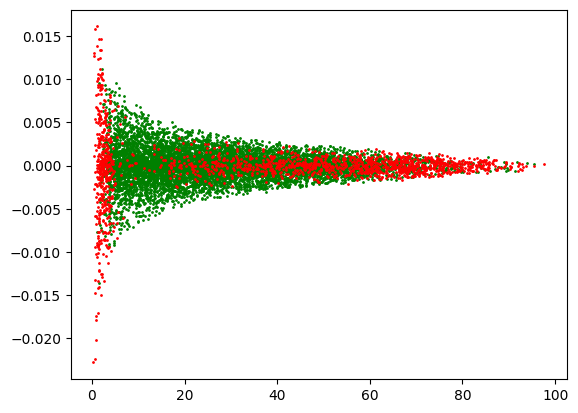

In [13]:
import matplotlib.pyplot as plt
plt.scatter(linked_obj_list['helioDist'], linked_obj_list['helioVel'], s=1, c='green')
plt.scatter(not_linked_obj_list['helioDist'], not_linked_obj_list['helioVel'], s=1, c='red')